# Fine-Tuning ResNet-50 Architecture

This notebook sets up the training pipeline for detecting whether an image was created by a human or an AI model using ResNet-50. <br>

ResNet-50 is a powerful convolutional neural network known for its deep architecture and residual connections, which help it learn complex patterns efficiently. It’s great at picking up subtle textures and visual cues — which is exactly what we need when trying to detect fake visuals that look almost real.

### What This Model Does:
- Starts with a pretrained ResNet-50 backbone.
- Replaces the final classification layer with a new one suited for our binary classification task: Human vs AI.
- Outputs a probability for each class using a sigmoid function.

<br>

In [1]:
%load_ext autoreload
%autoreload 2
%run ../setup.py

import yaml
import torch
import mlflow
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer
import torch.utils.data.dataset
import random
import torch.utils
import torch.utils.data
from src.utils.model_utils import save_model, load_model
from src.models.architectures.resNet import ModifiedResNet

Environment set up: sys.path updated, working dir set to project root.


## Configuration

In [7]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
# print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration


## Data Loading and Preprocessing

In [3]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

transform = Compose([
    Resize((128, 128)),
    # ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Dataset already exists at: /Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/dataset
Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


## Visualize Sample Images

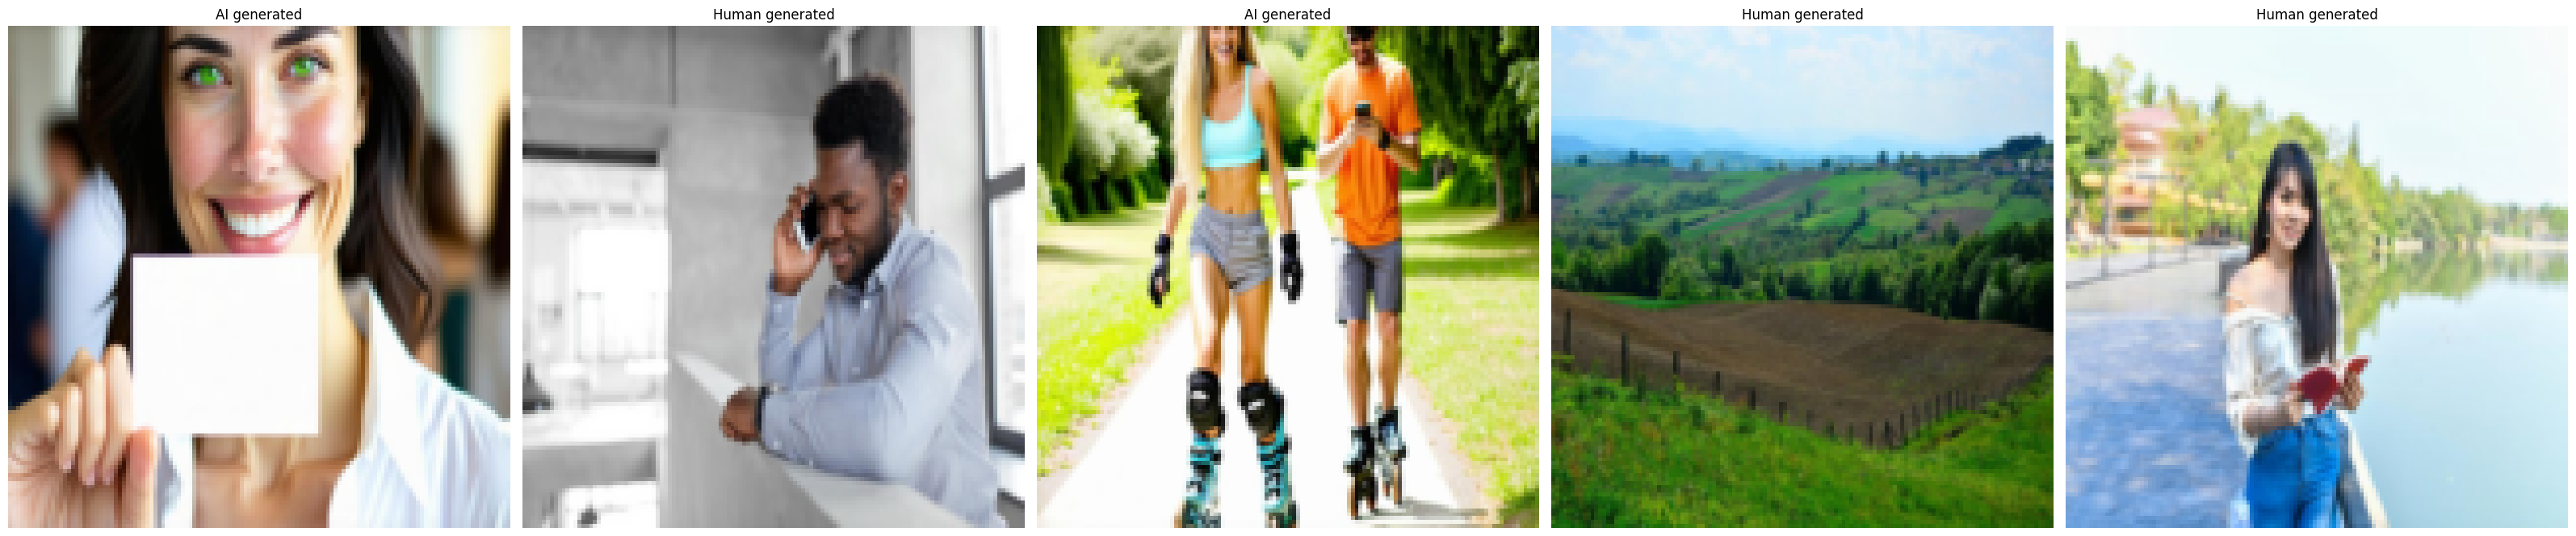

In [4]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(32, 16))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

## Model Training and Hyperparameter Tuning

**NOTE**: Uncommet the below code to test your model working on a smaller subset

In [7]:
# trainset_size = len(trainset)
# indices = random.sample(range(trainset_size), 1000)
# trainset = torch.utils.data.dataset.Subset(trainset, indices)

In [8]:
%load_ext autoreload
%autoreload 2

model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score, final_model = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
save_model(best_params, best_score, final_model, 'resNet')

Traceback (most recent call last):
  File "/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 310, in read_yaml
    raise MissingConfigException(f"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Skipping hyperparameter tuning and using default parameters.
Training resnet with default parameters


/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jaganathan.p/.conda/envs/MlProj/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Performing KFold Cross Validation with 3 folds
Epoch 1


Training: 100%|██████████| 1166/1166 [09:12<00:00,  2.11it/s, loss=0.18, acc=93]   


Epoch 2


Training: 100%|██████████| 1166/1166 [06:17<00:00,  3.09it/s, loss=0.108, acc=96]   


Epoch 3


Training: 100%|██████████| 1166/1166 [05:43<00:00,  3.40it/s, loss=0.0896, acc=96.7]


Accuracy obtained on Fold 1: 0.9508978826051997
Epoch 1


Training: 100%|██████████| 1166/1166 [06:07<00:00,  3.17it/s, loss=0.0755, acc=97.3]


Epoch 2


Training: 100%|██████████| 1166/1166 [05:58<00:00,  3.25it/s, loss=0.064, acc=97.7] 


Epoch 3


Training: 100%|██████████| 1166/1166 [06:20<00:00,  3.07it/s, loss=0.0538, acc=98.1]


Accuracy obtained on Fold 2: 0.9633342267488609
Epoch 1


Training: 100%|██████████| 1166/1166 [05:57<00:00,  3.26it/s, loss=0.0546, acc=98.1]


Epoch 2


Training: 100%|██████████| 1166/1166 [06:04<00:00,  3.20it/s, loss=0.0478, acc=98.3]


Epoch 3


Training: 100%|██████████| 1166/1166 [04:58<00:00,  3.90it/s, loss=0.0377, acc=98.6]


Accuracy obtained on Fold 3: 0.990136692575717
Mean score obtained from KFold: 0.9681229339765925
Best parameters: {'num_classes': 1}
Best score: 0.9681229339765925
Model saved to trained_models/resNet.pt


## Training Visualization

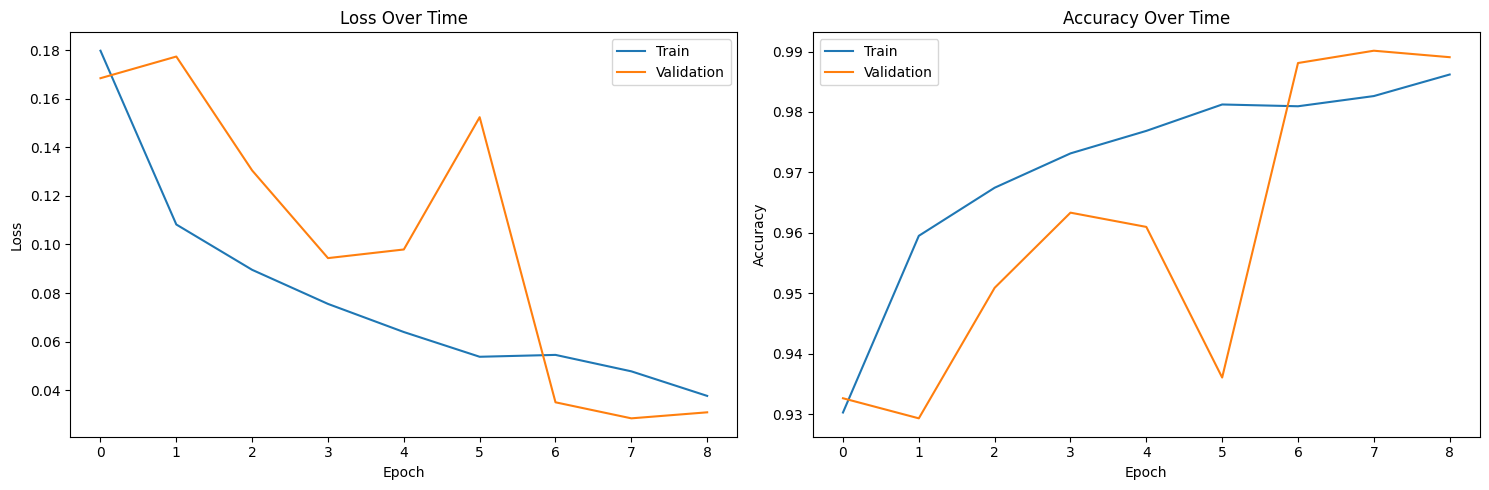

In [9]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

In [13]:
model, params, acc = load_model(
    ModifiedResNet, 
    'trained_models/resNet.pt'
    )
model

/home/jaganathan.p/GeneratedImageDetector/human-ai-image-detection/src/utils/model_utils.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_p

Model loaded from trained_models/resNet.pt, with score: 0.9681229339765925


ModifiedResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [14]:
valloader = torch.utils.data.DataLoader(valset)
val_loss, val_acc = trainer._evaluate(model, valloader)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

Validation Loss: 0.03755192905391735
Validation Accuracy: 0.9872837189910361


### Loading trained model for random testing

/Users/prashanthjaganathan/miniconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prashanthjaganathan/miniconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/src/training/trainer.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which wi

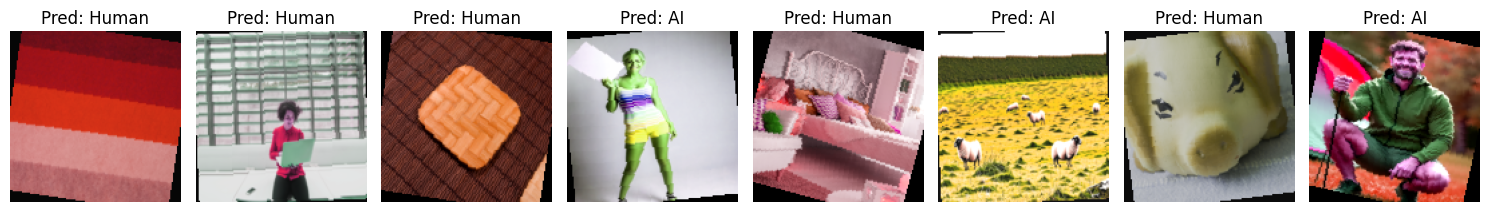

In [28]:
model_factory = ModelFactory()
model_name = 'resNet'

base_params = config['models'][model_name].get('base_params') or {}  # Fallback to empty dict if None
model = model_factory.get_model(model_name, **base_params)
model_path = f"trained_models/{model_name}.pt"

ModelTrainer.test_random(
    # modifies the images with color jitters, cropping, etc
    model_path=model_path,
    model=model,
    num_images=8,
    csv_path="dataset/test.csv"
)